In [ ]:
!pip install cvxpy numdifftools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cvxpy as cp
import numpy as np
import numdifftools as nd
import tqdm
import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_spd_matrix
import random

# Пункт 1

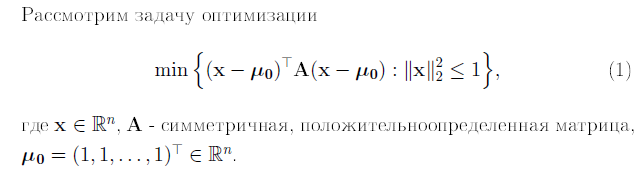

Пункт 1.

Рассмотрим задачу оптимизации:

$\min{\{(x - \mu_0)^T \cdot A \cdot  (x - \mu_0) : \| x \|^2_2 \leq  1 \}}$,

где $x \in \mathbb{R}^n $, $A$ - симметричная, положительно определенная матрица,
$\mu_0=(1, 1, ..., 1)^T\in\mathbb{R}^n.$



## Запишем двойственную задачу

$$
\begin{gather*}
\min\bigl((x-\mu_0)^T\cdot A\cdot (x-\mu_0)\bigl),\\
\text{где $\mu_0=(1, 1, ..., 1)^T\in\mathbb{R}^n$,$A$ - симметричная, положительно определенная матрица.}\\
\text{При ограничении: $\|x\|^2_2 \leq1$}
\end{gather*}
$$

Составим функцию Лагранжа:

$\mathcal{L}(x,\lambda) = (x-\mu_0)^T \cdot A \cdot (x-\mu_0)+\lambda(\|x\|^2_2-1)$

Найдем $\min\limits_{x} \mathcal{L}(x,\lambda)$. Так как функция выпукла:

$$
\begin{gather*}
\nabla_x\mathcal{L}_x(x,\lambda)= \bigl((x-\mu_0)^T \cdot A \cdot (x-\mu_0)\bigl)'_x+\bigl(\lambda(\|x\|^2_2-1)\bigl)'_x = 0
\end{gather*}
$$

В предыдущей лабе мы доказали, что:
\begin{align}
\\ \frac{\partial (x^T \cdot A \cdot x)}{\partial \mathbf x}&=\begin{pmatrix} 2 \sum_{i=1}^na_{1i}x_i \\ \vdots\\ 2 \sum_{i=1}^na_{ni}x_i \end{pmatrix} \\&=2\begin{pmatrix} a_{11} & a_{12} & \dots & a_{1n}\\  \vdots & \vdots &\ddots & \vdots \\ a_{n1} & a_{n2} & \dots & a_{nn} \end{pmatrix}\begin{pmatrix}x_1  \\ \vdots \\ x_n \end{pmatrix}\\ &= 2A\mathbf x
\end{align}

$(\|x\|^2_2)' = (x_1^2 + x_2^2 + ... + x_n^2)' = \begin{pmatrix} 2 x_1 \\ \vdots\\ 2 x_n \end{pmatrix} = 2x$

Таким образом,
$$
\begin{gather*}
\nabla_x\mathcal{L}_(x,\lambda)= \bigl((x-\mu_0)^T \cdot A \cdot (x-\mu_0)\bigl)'_x+\bigl(\lambda(\|x\|^2_2-1)\bigl)'_x = 0 =2 \cdot A \cdot (x-\mu_0)+ 2 \cdot \lambda \cdot x=0
\end{gather*}
$$


$(A+\lambda) \cdot x = A \cdot \mu_0$

$x=(A+\lambda)^{-1} \cdot A \cdot \mu_0$

Матрица $(A+\lambda)^{-1}$ обратима, так как A положительно определенная матрица, $\lambda > 0$ => собственные числа полученной матрицы будут положительными. А так как определитель равен произведению собственных чисел, то матрица обратима.

Получаем двойственную задачу:

$g(\lambda)=((A+\lambda)^{-1} \cdot A \cdot \mu_0 - \mu_0)^T \cdot A \cdot ((A+\lambda)^{-1} \cdot A \cdot \mu_0 - \mu_0)+\lambda(\|(A+\lambda)^{-1} \cdot A \cdot \mu_0\|^2_2-1), \lambda \ge 0$



## Применим метод из лабораторной работы №1 к двойственной задаче

In [ ]:
def make_projection_inv(x):
  return max(x, 0)

def make_lambda_inv():
  return max(np.random.randn(1) + 1, 0)

def fu_obj_inv(A):
    def f(lambda_):
        mu_0 = np.ones(A.shape[0])
        x = np.linalg.inv(A + lambda_ * np.eye(A.shape[0])) @ A @ mu_0
        return (x - mu_0).T @ A @ (x - mu_0) + lambda_ * ((np.linalg.norm(x) ** 2) - 1)
    return f

def fu_obj_grad_inv(A):
    def f(x):
        # x is lambda
        mu_0 = np.ones(A.shape[0])
        T_0 = np.linalg.inv(A + x * np.eye(A.shape[0]))
        t_1 = T_0 @ A @ mu_0
        t_2 = T_0 @ t_1
        return -(np.linalg.norm(t_1) ** 2 - 1 + mu_0.T @ A @T_0 @ T_0 @ A @ (t_1 - mu_0) +
                (mu_0.T @ A @T_0 + (-mu_0).T) @ A @ t_2 - 2 * x * mu_0.T @ A @ T_0 @ t_2)
    return f

In [ ]:

N = 10
n_starts = 10
max_iters = 500
errs = np.zeros(max_iters + 2)
n_range = range(10, 101, 10)
overall_iters = 0

pbar = tqdm.tqdm(total=10 * N * n_starts, position=0, leave=True)
for n in n_range:
    undertrained_count = 0
    for i in range(N):
        a = data[n][i]["A"]
        # print(a.shape)
        u, s, vt = np.linalg.svd(a)
        beta = s[0]
        alpha = s[-1]
        nu = 2 / (alpha + beta)

        for start in range(n_starts):
            x = make_lambda_inv()
            y = fu_obj_inv(a)(x)
            iter_num = 0
            while not np.isclose(y, data[n][i]["y_true"], atol=eps):
                if iter_num == max_iters:
                    undertrained_count += 1
                    break
                errs[iter_num] += np.linalg.norm(y - data[n][i]["y_true"])
                obj_grad = fu_obj_grad_inv(a)(x)
                x += nu * obj_grad   # fu_obj_grad(a)(x)
                x = make_projection_inv(x)
                y = fu_obj_inv(a)(x)

                iter_num += 1
            overall_iters += iter_num
            pbar.update(1)
        overall_iters = overall_iters / N / n_starts
    if undertrained_count:
        print(f"{undertrained_count} / {N * n_starts} undertrained cases on size {n}")

 10%|█         | 103/1000 [00:07<01:23, 10.76it/s]

37 / 100 undertrained cases on size 10


 20%|██        | 204/1000 [00:13<00:24, 33.12it/s]

29 / 100 undertrained cases on size 20


 30%|███       | 300/1000 [00:24<01:33,  7.52it/s]

20 / 100 undertrained cases on size 30


 40%|████      | 401/1000 [00:40<00:57, 10.42it/s]

29 / 100 undertrained cases on size 40


 50%|████▉     | 499/1000 [01:03<02:35,  3.23it/s]

29 / 100 undertrained cases on size 50


 60%|██████    | 601/1000 [01:28<02:11,  3.04it/s]

19 / 100 undertrained cases on size 60


 70%|███████   | 701/1000 [01:54<02:23,  2.09it/s]

28 / 100 undertrained cases on size 70


 80%|███████▉  | 799/1000 [02:19<00:41,  4.87it/s]

26 / 100 undertrained cases on size 80


 90%|█████████ | 900/1000 [02:57<00:34,  2.88it/s]

21 / 100 undertrained cases on size 90


100%|██████████| 1000/1000 [03:50<00:00,  4.81it/s]

32 / 100 undertrained cases on size 100


Градиентным спуском из первой лабораторной работы двойственная задача к исходной решается хорошо. (примерно 70-80% точек в итоге скатываются к локальному максимуму целевой функции двойственной *задачи*).

# Пункт 2

Для метода из ЛР №1 замените градиент на стохастический градиент 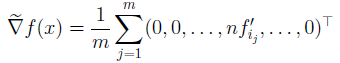и примените метод SGD для различных параметров  $m \in \left \{1, \frac{n}{8}, \frac{n}{4}, \frac{n}{2}, n   \right \}$

Сначал генерируем данные, как в первой лабе и решаем задачи с помощью CVX:

In [ ]:
n_range = range(10, 101, 10)
N = 100
data = {}

pbar = tqdm.tqdm(total=10*N, position=0, leave=True)
for n in n_range:
    mu_0 = np.ones(n)
    data[n] = {}
    for i in range(N):
        # B = np.random.exponential(10, (n, n))
        # B = np.random.rand(n,n)
        # A = np.dot(B, B.T)
        A = make_spd_matrix(n)

        data[n][i] = {}
        data[n][i]['A'] = A

        x = cp.Variable(n)

        obj = cp.Minimize(cp.quad_form(x - mu_0, A))
        constraints = [cp.norm(x) <= 1]

        prob = cp.Problem(obj, constraints)
        try:
            prob.solve()
        except cp.SolverError:
            prob.solve(solver=cp.SCS)

        # print("Optimal value: ", prob.value)
        # print("Optimal solution: ", x.value)

        data[n][i]['x_true'] = x.value
        data[n][i]['y_true'] = prob.value
        pbar.update(1)


100%|██████████| 1000/1000 [01:22<00:00,  5.10it/s]

In [ ]:
def fu_obj(A):
    def f(x):
        mu_0 = np.ones(x.shape[0])
        return (x - mu_0).T @ A @ (x - mu_0)
    return f

def fu_lim(x):
    return np.sum(x ** 2) - 1

In [ ]:
def fu_obj_grad(A, x):
    mu_0 = np.ones(x.shape[0])
    return 2 * A @ (x - mu_0)

def fu_lim_grad(x):
    return 2*x

In [ ]:
%%time
rtol = 0.001
N = 100
good_cnt2 = 0
bads2 = []
for n in tqdm.tqdm(n_range):
    for i in range(N):
        cur_x, cur_a = data[n][i]['x_true'], data[n][i]['A']
        obj_grad = fu_obj_grad(cur_a, cur_x)
        lim_grad = fu_lim_grad(cur_x)

        cos = np.dot(-obj_grad, lim_grad) / np.linalg.norm(obj_grad) / np.linalg.norm(lim_grad)
        if np.isclose(cos, 1, rtol=rtol):
            good_cnt2+=1
        else:
            bads2.append(cos)


100%|██████████| 10/10 [00:00<00:00, 66.07it/s]

CPU times: user 157 ms, sys: 29.1 ms, total: 186 ms
Wall time: 169 ms


In [ ]:
print(f'Процент тестов, "непрошедших" условие оптимальности {100 * (1 - good_cnt2 / 1e3)}')

Процент тестов, "непрошедших" условие оптимальности 0.0


In [ ]:
good_cnt2

100

In [ ]:
def make_projection(x):
  norm = np.linalg.norm(x)
  if norm > 1:
      return x / np.linalg.norm(x)
  return x

def make_x(n):
  return make_projection(np.random.rand(n)*2-1)

Просто так в данном методе функциии не сходились в оптимальным значениям, поэтому стоит уделить внимание выбору шага

## Searching optimal Learning Rate

In [ ]:
start_cur = 0
eps = 0.01

def run_test(n_cur, i_cur, m, allow_replace, lr, max_iters):
    errs = []
    a = data[n_cur][i_cur]["A"]
    u, s, vt = np.linalg.svd(a)
    beta = s[0]
    alpha = s[-1]
    nu = 2 / (alpha + beta) / lr
    x = make_x(n_cur)
    y = fu_obj(a)(x)
    iter_num = 0
    while not np.isclose(y, data[n_cur][i_cur]["y_true"], atol=eps):
        errs.append(np.linalg.norm(y - data[n_cur][i_cur]["y_true"]))
        if iter_num == max_iters:
            break
        sum_grad = np.zeros(n_cur)
        indices = np.random.choice(n_cur, m, replace=allow_replace)
        for idx in indices:
            sum_grad[idx] += n * fu_obj_grad(a[idx], x)
        sum_grad /= n_cur
        x -= nu * sum_grad
        x = make_projection(x)
        y = fu_obj(a)(x)
        iter_num += 1
    return errs

In [ ]:
def plot_test_res(y, start=0):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(2):
        for j in range(3):
            x = range(start, len(y[i * 3 + j]))
            axs[i, j].plot(x, y[i * 3 + j][start:])
            axs[i, j].set_title(f'Axis [{i}, {j}]')

In [ ]:
dimension = 10
m = int(dimension / 2)
A_ids = [5, 7, 9, 15, 77, 85]
point_errors = [0 for i in range(len(A_ids))]
for i, id in enumerate(A_ids):
    point_errors[i] = run_test(dimension, id, m, True, 1)

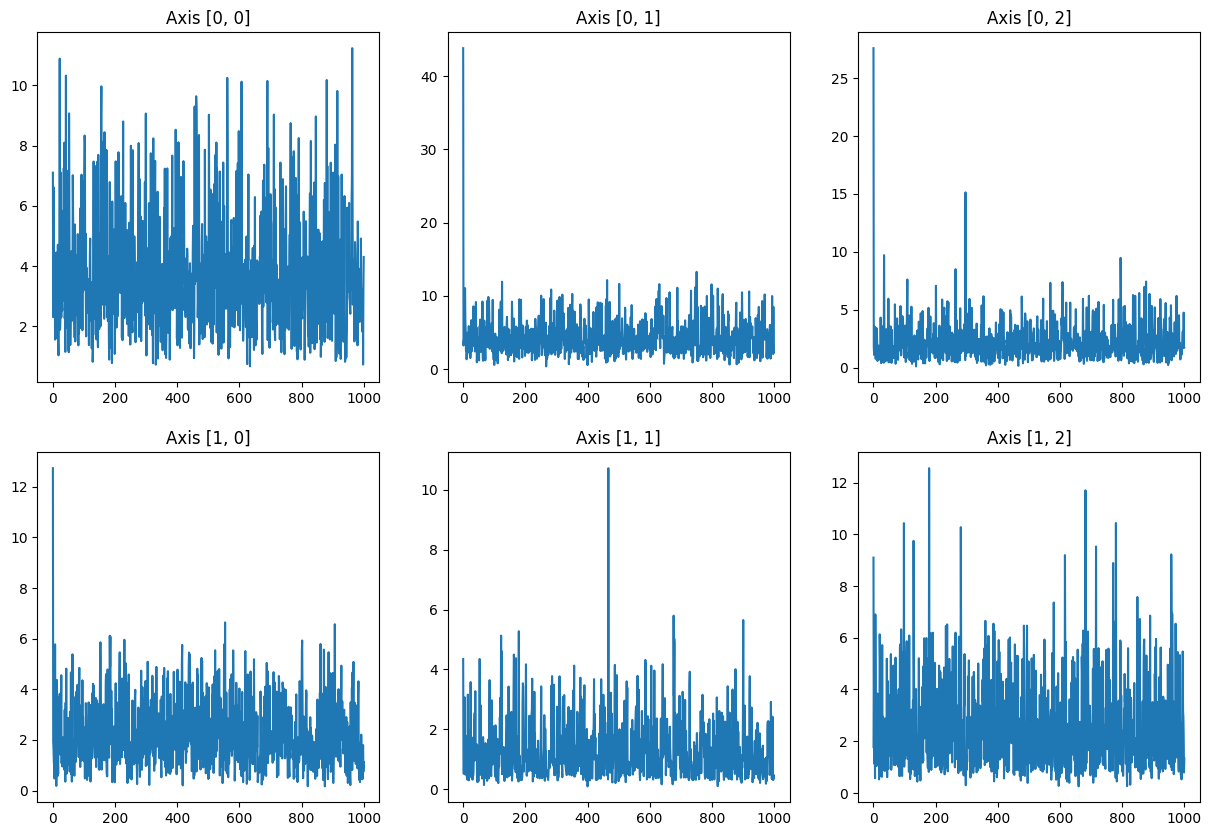

In [ ]:
plot_test_res(point_errors)

Из графиков видно, что шаг очень большой и значение целевой фунцкии очень сильно колеблется и не сходится к минимуму даже за 1000 итераций. Попробуем уменьшить скорость сходимости.

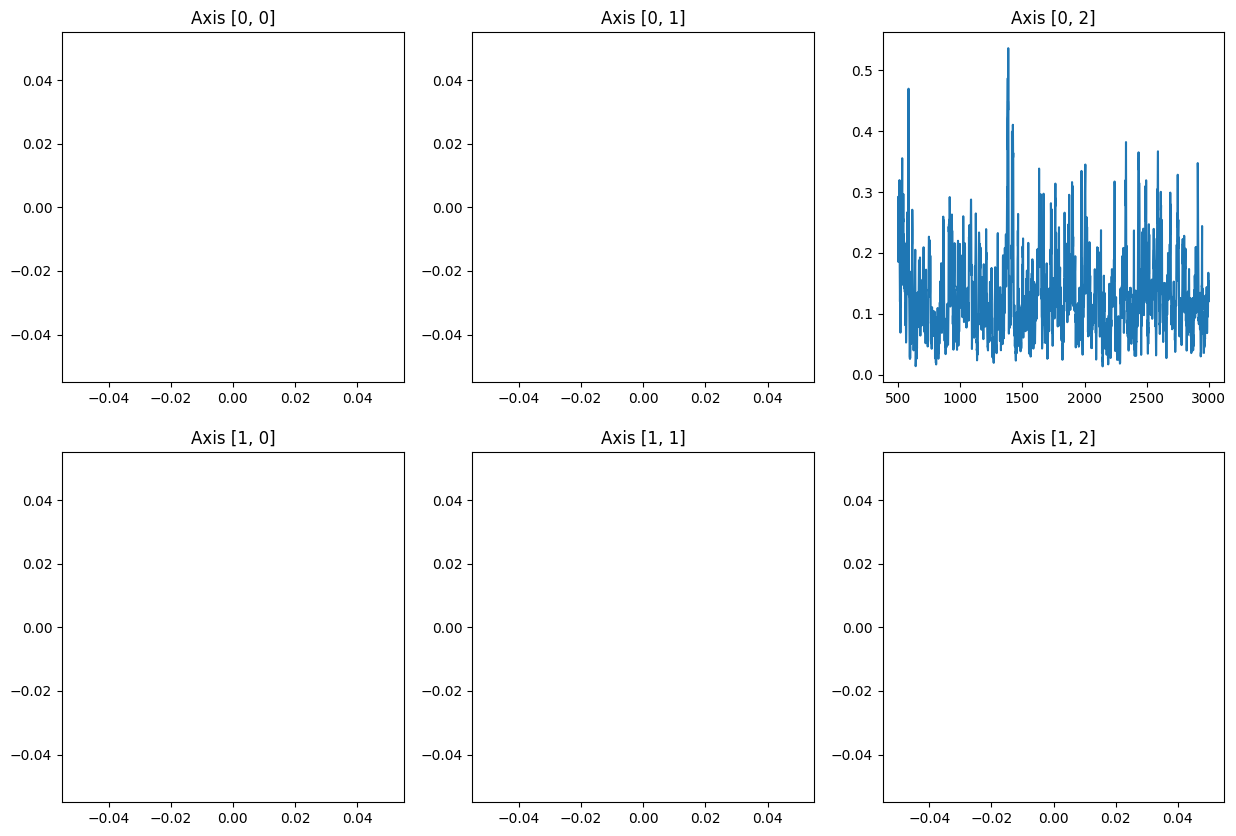

In [ ]:
dimension = 10
m = int(dimension / 2)
A_ids = [75, 77, 79, 55, 57, 65]
point_errors = [0 for i in range(len(A_ids))]
for i, id in enumerate(A_ids):
    point_errors[i] = run_test(dimension, id, m, True, 120, 3000)
plot_test_res(point_errors, 500)

Уменьшив шаг в 100 раз (в 10 не помогло, убрали для компактности отчета), целевая функция начала сходиться методом стохастического градиентного спуска. Теперь попробуем взять другие размерности (т.к. до этого работали только с dim = 10), чтобы понять, будет ли работать такой шаг или же есть зависимость от размерности.

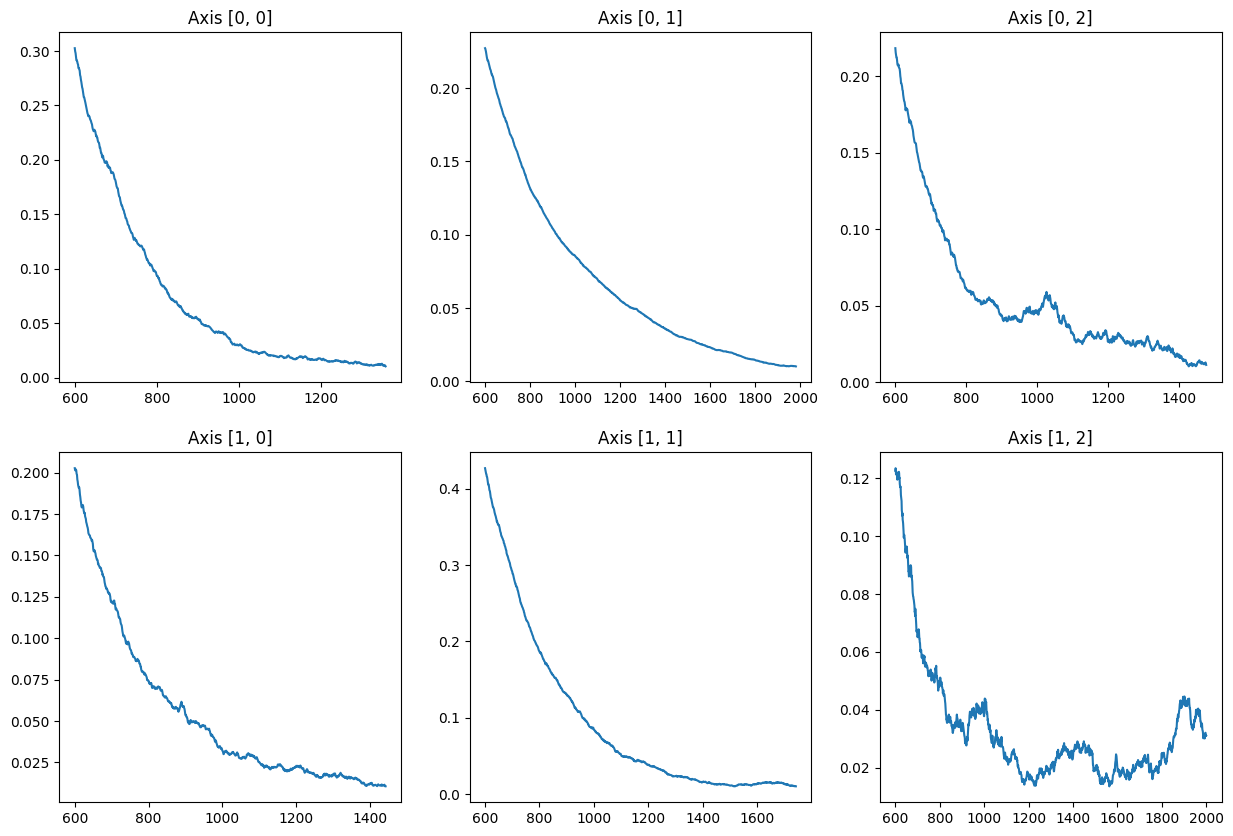

In [ ]:
dimension = 50
m = int(dimension / 2)
A_ids = [66, 68, 61, 67, 65, 35]
point_errors = [0 for i in range(len(A_ids))]
for i, id in enumerate(A_ids):
    point_errors[i] = run_test(dimension, id, m, False, 250, 2000)
plot_test_res(point_errors, 600)

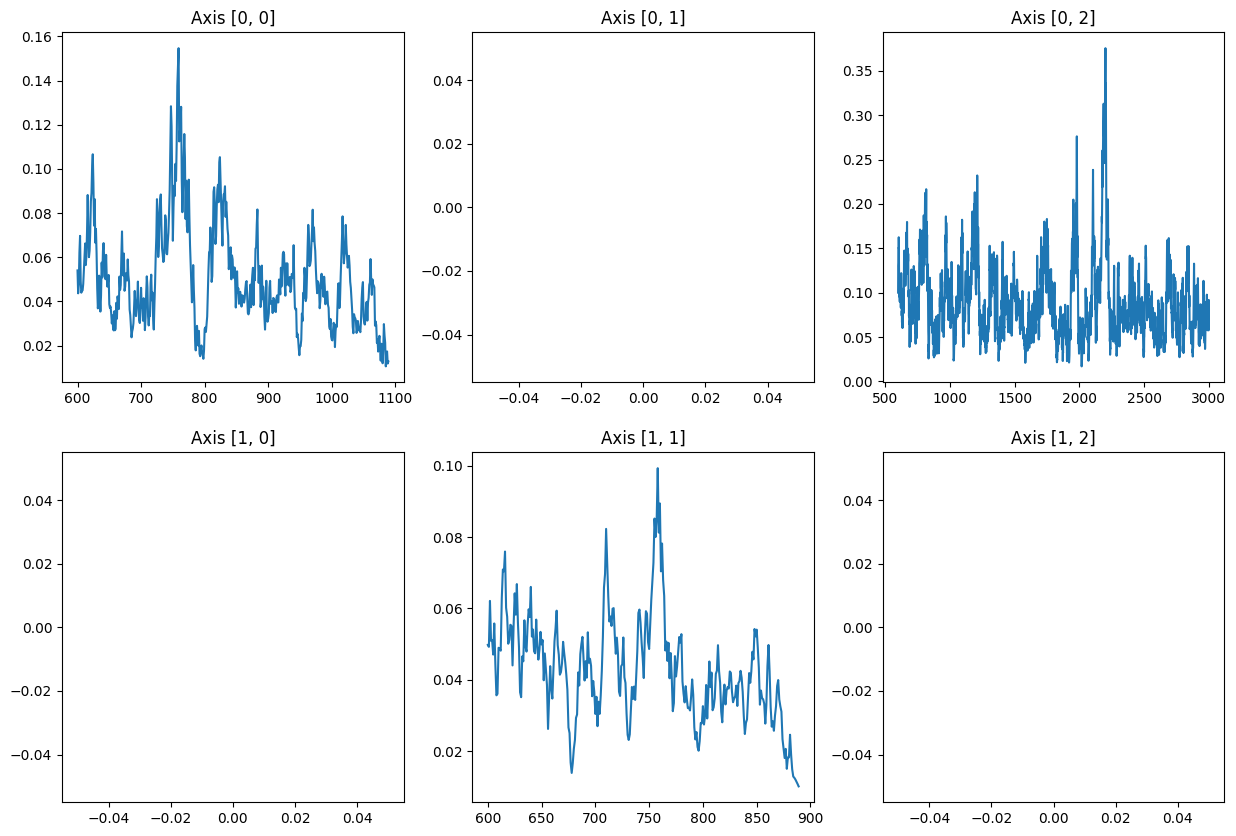

In [ ]:
dimension = 20
m = int(dimension / 2)
A_ids = [56, 58, 51, 57, 55, 35]
point_errors = [0 for i in range(len(A_ids))]
for i, id in enumerate(A_ids):
    point_errors[i] = run_test(dimension, id, m, False, 100, 3000)
plot_test_res(point_errors, 600)

Было много экспериментов. Мы их отсюда убрали, чтобы не загромождать отчет неудавшимися графиками.

<b>Short Summary:</b>

- на небольших размерностях функция работает и находит оптимальное решение за малое время работы (достаточно 1000 итераций при точности $ϵ$ = 0.01)

- на больших размерностях стохастический градиент с возможностью выбора одной компоненты несколько раз переставал сходиться в бОльшем количестве точек (пробовали различные комбинации параметров - число компонент, размер шага)

- исходя из этого, попробовали выбирать уникальные компоненты на каждой итерации - дало положительный эффект

-  зависимость шага SGD от размерности была выявлена экспериментально для каждой из размерностей





Это формулы, относящиеся к выбору уникальных компонент из градиента:

Как мы видим, если повторяются индексы, то метод SGD не сходится из большинства исходных точке ( больше 90% ).

$E (\tilde{\bigtriangledown} f(x)) = \sum_{i=1}^{n} \frac{m}{n} * \begin{pmatrix}0
 \\...
 \\n * f'_{x_i}
 \\...
 \\0
\end{pmatrix} / m = \bigtriangledown f(x)$, где $\frac{m}{n}$ - вероятность, что i-й элемент попадет в градиент ( $\frac{C_{n-1}^{m-1}}{C_n^m}$ )



$ \lim_{N \to \inf} \frac{1}{N}\sum_{i = 1}^{N}\tilde{\bigtriangledown }f(x) = \bigtriangledown f(x)$
<br>
<br>

Теперь перейдем к тестам :

In [ ]:
def run_sgd(N, n_starts, n_cur, m, allow_replace, lr, max_iters):
    undertrained_count = 0
    for i_cur in range(N):
        a = data[n_cur][i_cur]["A"]
        u, s, vt = np.linalg.svd(a)
        beta = s[0]
        alpha = s[-1]
        nu = 2 / (alpha + beta) / lr
        for start in range(n_starts):
            iter_num = 0
            x = make_x(n_cur)
            y = fu_obj(a)(x)
            while not np.isclose(y, data[n_cur][i_cur]["y_true"], atol=eps):
                if iter_num == max_iters:
                    undertrained_count += 1
                    break
                sum_grad = np.zeros(n_cur)
                indices = np.random.choice(n_cur, m, replace=allow_replace)
                for idx in indices:
                    sum_grad[idx] += n * fu_obj_grad(a[idx], x)
                sum_grad /= n_cur
                x -= nu * sum_grad
                x = make_projection(x)
                y = fu_obj(a)(x)
                iter_num += 1
            pbar.update(1)
    if undertrained_count:
        print(f"{undertrained_count / N * n_starts} % undertrained cases on size {n_cur}")
    return iter_num

# Пункт 3

## Подпункт 3.1
3.1. Для заданной точности $ɛ>0$ по значению целевой функции и для каждого значения $n\in\{10,20,..100\}$ и $m\in \{1, \frac{n}{8}, \frac{n}{4}, \frac{n}{2}, n\}$ подсчитайте среднее число арифметических операций во всех 3-х рассмотренных методах (усреднение проводится по всем начальным точкам и по всем тестовым примерам). Если число операций подсчитать не удается, то укажите среднее время работы метода. Какой метод работает лучше и почему?

In [ ]:
%%time

N = 10
n_starts = 10
lrs = [120, 100, 150, 200, 120, 120, 150, 200, 150, 120]
ms = ["1", "n/2", "n/4", "n/8", "n"]

opers_cnt = {"1": [], "n/2": [], "n/4": [], "n/8": [], "n": []}

pbar = tqdm.tqdm(total=10*5*N*n_starts, position=0, leave=True)
for lr_id, dim in enumerate(n_range):
    for m_str, m in enumerate([1, int(dim/8), int(dim/4), int(dim/2), int(dim)]):
        opers = run_sgd(N, n_starts, dim, m, False, lrs[lr_id], 2000)
        opers *= ((dim * m + m) / N / n_starts )
        opers_cnt[ms[m_str]].append(opers)

  2%|▏         | 101/5000 [00:18<11:13,  7.27it/s]

31.0 % undertrained cases on size 10


  4%|▍         | 203/5000 [00:35<06:34, 12.15it/s]

30.0 % undertrained cases on size 10


  6%|▌         | 308/5000 [00:46<02:52, 27.15it/s]

14.0 % undertrained cases on size 10


  8%|▊         | 411/5000 [00:52<02:15, 33.99it/s]

3.0 % undertrained cases on size 10


 12%|█▏        | 600/5000 [01:28<20:24,  3.59it/s]

99.0 % undertrained cases on size 20


 14%|█▍        | 701/5000 [01:55<14:53,  4.81it/s]

69.0 % undertrained cases on size 20


 16%|█▌        | 800/5000 [02:20<22:59,  3.05it/s]

28.0 % undertrained cases on size 20


 18%|█▊        | 903/5000 [02:35<04:56, 13.84it/s]

6.0 % undertrained cases on size 20


 22%|██▏       | 1100/5000 [03:09<20:31,  3.17it/s]

100.0 % undertrained cases on size 30


 24%|██▍       | 1200/5000 [03:41<20:54,  3.03it/s]

100.0 % undertrained cases on size 30


 26%|██▌       | 1300/5000 [04:17<18:59,  3.25it/s]

43.0 % undertrained cases on size 30


 28%|██▊       | 1402/5000 [04:48<09:10,  6.53it/s]

7.0 % undertrained cases on size 30


 32%|███▏      | 1600/5000 [05:30<16:28,  3.44it/s]

100.0 % undertrained cases on size 40


 34%|███▍      | 1700/5000 [06:07<17:58,  3.06it/s]

100.0 % undertrained cases on size 40


 36%|███▌      | 1800/5000 [06:57<25:59,  2.05it/s]

91.0 % undertrained cases on size 40


 38%|███▊      | 1900/5000 [07:45<18:18,  2.82it/s]

30.0 % undertrained cases on size 40


 40%|████      | 2000/5000 [08:16<08:55,  5.60it/s]

2.0 % undertrained cases on size 40


 42%|████▏     | 2100/5000 [08:46<16:21,  2.96it/s]

100.0 % undertrained cases on size 50


 44%|████▍     | 2200/5000 [09:27<25:08,  1.86it/s]

100.0 % undertrained cases on size 50


 46%|████▌     | 2300/5000 [10:23<32:03,  1.40it/s]

85.0 % undertrained cases on size 50


 48%|████▊     | 2400/5000 [11:25<38:12,  1.13it/s]

37.0 % undertrained cases on size 50


 52%|█████▏    | 2600/5000 [12:31<12:01,  3.33it/s]

100.0 % undertrained cases on size 60


 54%|█████▍    | 2700/5000 [13:14<14:37,  2.62it/s]

100.0 % undertrained cases on size 60


 56%|█████▌    | 2800/5000 [14:15<23:30,  1.56it/s]

100.0 % undertrained cases on size 60


 58%|█████▊    | 2900/5000 [15:34<18:40,  1.87it/s]

43.0 % undertrained cases on size 60


 62%|██████▏   | 3100/5000 [16:46<10:48,  2.93it/s]

100.0 % undertrained cases on size 70


 64%|██████▍   | 3200/5000 [17:34<17:46,  1.69it/s]

100.0 % undertrained cases on size 70


 66%|██████▌   | 3300/5000 [18:41<16:15,  1.74it/s]

100.0 % undertrained cases on size 70


 68%|██████▊   | 3400/5000 [20:21<24:22,  1.09it/s]

63.0 % undertrained cases on size 70


 70%|███████   | 3500/5000 [21:29<11:21,  2.20it/s]

10.0 % undertrained cases on size 70


 72%|███████▏  | 3600/5000 [22:00<08:07,  2.87it/s]

100.0 % undertrained cases on size 80


 74%|███████▍  | 3700/5000 [22:51<11:28,  1.89it/s]

100.0 % undertrained cases on size 80


 76%|███████▌  | 3800/5000 [24:03<12:21,  1.62it/s]

100.0 % undertrained cases on size 80


 78%|███████▊  | 3900/5000 [25:59<20:52,  1.14s/it]

97.0 % undertrained cases on size 80


 80%|████████  | 4000/5000 [28:13<27:46,  1.67s/it]

30.0 % undertrained cases on size 80


 82%|████████▏ | 4100/5000 [28:44<05:25,  2.76it/s]

100.0 % undertrained cases on size 90


 84%|████████▍ | 4200/5000 [29:36<08:42,  1.53it/s]

100.0 % undertrained cases on size 90


 86%|████████▌ | 4300/5000 [31:13<09:12,  1.27it/s]

100.0 % undertrained cases on size 90


 88%|████████▊ | 4400/5000 [33:18<13:27,  1.35s/it]

98.0 % undertrained cases on size 90


 90%|█████████ | 4500/5000 [35:26<10:51,  1.30s/it]

10.0 % undertrained cases on size 90


 92%|█████████▏| 4600/5000 [36:12<02:39,  2.51it/s]

100.0 % undertrained cases on size 100


 94%|█████████▍| 4700/5000 [37:40<04:25,  1.13it/s]

100.0 % undertrained cases on size 100


 96%|█████████▌| 4800/5000 [40:03<04:20,  1.30s/it]

100.0 % undertrained cases on size 100


 98%|█████████▊| 4900/5000 [43:50<03:43,  2.24s/it]

98.0 % undertrained cases on size 100


100%|██████████| 5000/5000 [46:58<00:00,  4.04s/it]

10.0 % undertrained cases on size 100
CPU times: user 45min 10s, sys: 9min 55s, total: 55min 5s
Wall time: 46min 58s


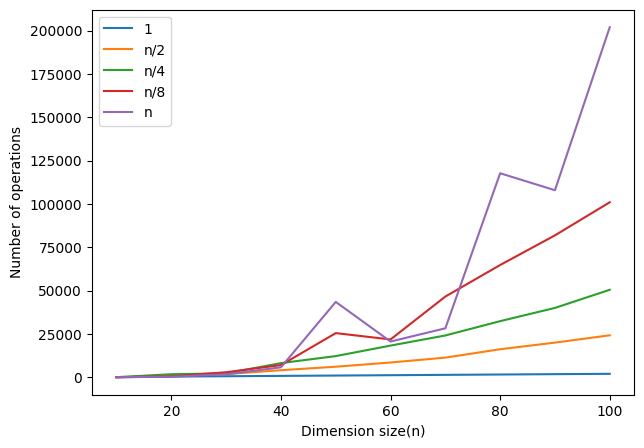

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(5)

for key in opers_cnt:
    plt.plot(n_range, opers_cnt[key], label=key, )
plt.xlabel("Dimension size(n)")
plt.ylabel("Number of operations")
plt.legend()
plt.show()

Из графика видно, что с увеличением размерности число операций растет. При m = n, оно растет квадратично,  в остальных случаях чуть медленнее, поскольку на одну итерацию SGD нам требуется n * m + m арифметических операций. Однако, как э то видно из результатов тестирования, для больших размерностей реализованный метод находит малое число точек.

## Подпункт 3.2
Для одного тестового примера $n=10$ и нескольких различных начальных точек постройте зависимость точности от числа арифметических операций в методах градиентного и стохастического градиентного спуска, примененных для исследуемой задачи. Если число операций подсчитать не удается, то постройте зависимость средней точности от времени работы метода.

Gradient descent

In [ ]:
n_starts = 100
eps = 0.01
max_iter = 100
cur_i = 1

def grad_descent(n):
    errs = np.zeros(max_iters)
    iters_counts = np.full_like(np.zeros(max_iters), 1e-5)  # to avoid zero division

    a = data[n][cur_i]["A"]
    u, s, vt = np.linalg.svd(a)
    beta = s[0]
    alpha = s[-1]
    nu = 2 / (alpha + beta)

    for start in range(n_starts):
        x = make_x(n)
        y = fu_obj(a)(x)
        iter_num = 0

        while not np.isclose(y, data[n][cur_i]["y_true"], atol=eps):
            if iter_num == max_iter:
                break
            errs[iter_num] += np.linalg.norm(y - data[n][i_cur]["y_true"])
            iters_counts[iter_num] += 1

            x -= nu * fu_obj_grad(a, x)
            x = make_projection(x)
            y = fu_obj(a)(x)
            iter_num += 1
    errs = errs / iters_counts
    return errs

Stochastic gradient descent

In [ ]:
max_iters = 1000
i_cur = 77
n_starts = 100


def stochastic_grad_descent(n_cur, m):
    m = int(n / m)
    errs = np.zeros(max_iters)
    errs_per_iter = np.full_like(np.zeros(max_iters), 1e-5)  # to avoid zero division

    a = data[n_cur][i_cur]["A"]
    u, s, vt = np.linalg.svd(a)
    beta = s[0]
    alpha = s[-1]
    nu = 2 / (alpha + beta) / 100
    for start_cur in range(1, n_starts):
        # O(n)
        x = make_x(n_cur)
        # O(n^2)
        y = fu_obj(a)(x)
        iter_num = 0
        # O(n^2 + n*m + 3*n)
        while not np.isclose(y, data[n_cur][i_cur]["y_true"], atol=eps):
            if iter_num == max_iters:
                break
            errs[iter_num] += np.linalg.norm(y - data[n_cur][i_cur]["y_true"])
            errs_per_iter[iter_num] += 1
            sum_grad = np.zeros(n_cur)

            # O(n * m)
            indices = np.random.choice(n_cur, m, replace = True)
            for idx in indices:
                sum_grad[idx] += n * fu_obj_grad(a[idx], x)

            # O(2*n)
            sum_grad /= n_cur
            x -= nu * sum_grad

            # O(n)
            x = make_projection(x)

            # O(n^2)
            y = fu_obj(a)(x)
            iter_num += 1
    errs = errs / errs_per_iter
    return errs

Plot for SGD

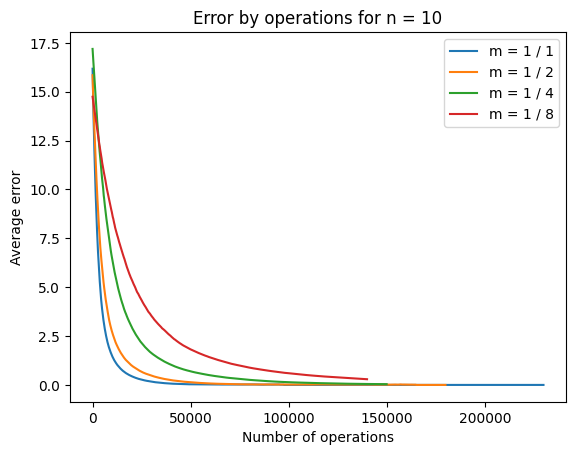

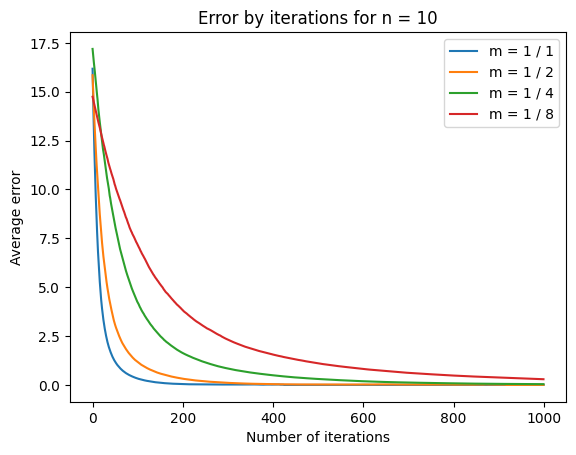

In [ ]:
import matplotlib.pyplot as plt


n = 10
errors = []
proportion_range = [1, 2, 4, 8]
for proportion in proportion_range:
    m = int(n / proportion)
    current_errors = stochastic_grad_descent(n, proportion)
    errors.append(current_errors)
    plt.plot(
        np.array([i * (n**2 + n * m + 3 * n) for i in range(len(current_errors))]),
        current_errors,
        label=f"m = 1 / {proportion}"
    )
plt.ylabel('Average error')
plt.xlabel('Number of operations')
plt.title('Error by operations for n = 10')
plt.legend()
plt.show()

for proportion, current_errors in zip(proportion_range, errors):
    plt.plot(current_errors, label=f"m = 1 / {proportion}")

plt.ylabel('Average error')
plt.xlabel('Number of iterations')
plt.title('Error by iterations for n = 10')
plt.legend()
plt.show()

Plot for GD

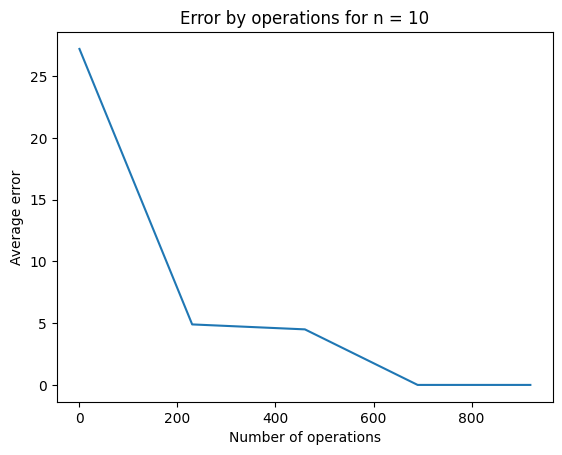

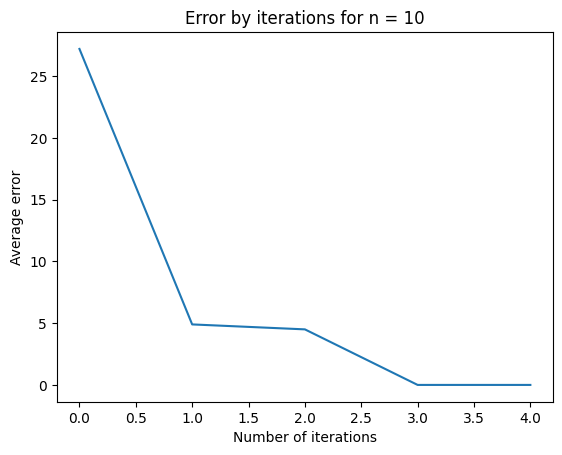

In [ ]:
n = 10
errors_gd = grad_descent(n)
plt.plot(
    np.array([i * (2 * n**2 + 3 * n) for i in range(len(errors_gd[:5]))]),
    errors_gd[:5]
)
plt.ylabel('Average error')
plt.xlabel('Number of operations')
plt.title('Error by operations for n = 10')
plt.show()

plt.plot(errors_gd[:5])
plt.ylabel('Average error')
plt.xlabel('Number of iterations')
plt.title('Error by iterations for n = 10')
plt.show()

Вывод по графикам 3.2:
* С увеличением числа арифметических операций значение ошибки падает для обычного и стохастического градиентного спуска
* Для стохастического градиентного спуска можем заметить, что для малой размерности (n=10), количество арифметических операций при малом m будет меньше. Но при больших n малое m даёт плохую сходимость и наоборот большое число операций.

# Какой метод работает лучше и почему?

Данная реализация стохастического градиентного спуска с выбором нескольких переменных для подсчёта градиента и занулением всех остальных компонент и с разрешением повтора их выбора сходится хуже, чем классический градиентный спуск. В нашей реализации так же важную роль решает доля переменных по которым идёт подсчёт градиента и особенно важен выбор шага (learning rate)